In [ ]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification

from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cuda device


In [ ]:
master_path = '/content/drive/MyDrive/MSc/modules/2.2/2.2-Language P-2/week9-fine_tuning/lab9resources/MRPC'

dev_path = '/content/drive/MyDrive/MSc/modules/2.2/2.2-Language P-2/week9-fine_tuning/lab9resources/MRPC/msr_paraphrase_dev.tsv'
test_path = '/content/drive/MyDrive/MSc/modules/2.2/2.2-Language P-2/week9-fine_tuning/lab9resources/MRPC/msr_paraphrase_test.tsv'
train_path = '/content/drive/MyDrive/MSc/modules/2.2/2.2-Language P-2/week9-fine_tuning/lab9resources/MRPC/msr_paraphrase_train.tsv'

df_train = pd.read_csv(train_path, delimiter='\t', on_bad_lines='warn')
df_dev = pd.read_csv(dev_path, delimiter='\t', on_bad_lines='warn')
df_test = pd.read_csv(test_path, delimiter='\t', on_bad_lines='warn')

print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)

(3938, 5)
(388, 5)
(1639, 5)


Skipping line 102: expected 5 fields, saw 6
Skipping line 656: expected 5 fields, saw 6
Skipping line 867: expected 5 fields, saw 6
Skipping line 880: expected 5 fields, saw 6
Skipping line 980: expected 5 fields, saw 6
Skipping line 1439: expected 5 fields, saw 6
Skipping line 1473: expected 5 fields, saw 6
Skipping line 1822: expected 5 fields, saw 6
Skipping line 1952: expected 5 fields, saw 6
Skipping line 2009: expected 5 fields, saw 6
Skipping line 2230: expected 5 fields, saw 6
Skipping line 2506: expected 5 fields, saw 6
Skipping line 2523: expected 5 fields, saw 6
Skipping line 2809: expected 5 fields, saw 6
Skipping line 2887: expected 5 fields, saw 6
Skipping line 2920: expected 5 fields, saw 6
Skipping line 2944: expected 5 fields, saw 6
Skipping line 3241: expected 5 fields, saw 6
Skipping line 3358: expected 5 fields, saw 6
Skipping line 3459: expected 5 fields, saw 6
Skipping line 3491: expected 5 fields, saw 6
Skipping line 3643: expected 5 fields, saw 6
Skipping line 3

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_stuff_from_df_classification(paraphrase_df):

  paraphrase_df['#1 String'] = paraphrase_df['#1 String'].astype(str)
  paraphrase_df['#2 String'] = paraphrase_df['#2 String'].astype(str)

  paraphrase_df['combined'] = paraphrase_df.apply(lambda row: f"{row['#1 String']} [SEP] {row['#2 String']}", axis=1)

  max_len = 256

  cat_0 = paraphrase_df.loc[paraphrase_df['Quality'] == 0, 'combined'].tolist()
  cat_1 = paraphrase_df.loc[paraphrase_df['Quality'] == 1, 'combined'].tolist()

  cat_0_input_embeddings = tokenizer(cat_0, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")
  cat_1_input_embeddings = tokenizer(cat_1, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")

  cat_0_input_embeddings['labels'] =  torch.tensor([0 for _ in range(len(cat_0))])
  cat_1_input_embeddings['labels'] =  torch.tensor([1 for _ in range(len(cat_1))])
  print(cat_0_input_embeddings['input_ids'].shape)
  # print(cat_0_input_embeddings['labels'].shape)

  data = {key: torch.cat([cat_0_input_embeddings[key], cat_1_input_embeddings[key]], dim=0) for key in cat_0_input_embeddings}
  return data
    # cat_0_output_embeddings = cat_0_output_embeddings[1]

    # cat_1_output_embeddings = model(cat_1_input_embeddings['input_ids'], token_type_ids=cat_1_input_embeddings['token_type_ids'], attention_mask=cat_1_input_embeddings['attention_mask'])
    # cat_1_output_embeddings = cat_1_output_embeddings[1]

  # cat0 = list(zip(cat_0_input_embeddings, [0 for _ in range(len(cat_0_input_embeddings))]))
  # cat1 = list(zip(cat_1_input_embeddings, [1 for _ in range(len(cat_1_input_embeddings))]))

  # return cat0 + cat1


In [ ]:
train_labelled_embeddings = get_stuff_from_df_classification(df_train)
dev_labelled_embeddings = get_stuff_from_df_classification(df_dev)
test_labelled_embeddings = get_stuff_from_df_classification(df_test)

torch.Size([1277, 256])
torch.Size([124, 256])
torch.Size([551, 256])


In [ ]:
dev_labelled_embeddings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [ ]:
class CustomParaphraseDataset(Dataset):
    def __init__(self, labelled_embeddings_dict):

        self.labelled_embeddings = labelled_embeddings_dict

    def __len__(self):
        return len(self.labelled_embeddings['input_ids'])

    def __getitem__(self, idx):
        input_ids, token_type_ids, attention_masks, label = [self.labelled_embeddings[key][idx] for key in self.labelled_embeddings.keys()]
        return {'input_ids':input_ids, 'token_type_ids': token_type_ids, 'attention_mask':attention_masks, 'labels':label}

In [ ]:
train_dataset = CustomParaphraseDataset(train_labelled_embeddings)
test_dataset = CustomParaphraseDataset(test_labelled_embeddings)
dev_dataset = CustomParaphraseDataset(dev_labelled_embeddings)

In [ ]:
batch_size_train = 75
batch_size_test = 22
batch_size_dev = 8

train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size_dev, shuffle=True)

In [ ]:
boop = next(iter(train_dataloader))
boop['input_ids'].shape


torch.Size([75, 256])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.train().to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from tqdm import tqdm

epochs = 10
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)

train_losses = []
train_accuracy = []
dev_losses = []
dev_accuracy = []


for epoch in range(epochs):
  train_running_losses = []
  train_total = 0
  train_correct = 0

  for i, batch in enumerate(tqdm(train_dataloader)):

    batch = {k: v.to(device) for k, v in batch.items()}

    outputs = model(**batch)

    loss = outputs[0]
    # print(outputs)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # Convert outputs to predicted labels (0 or 1 based on threshold 0.5)
    _, indices = torch.max(outputs['logits'], dim=1)
    predicted_labels = indices.float()

    # print(predicted_labels)
    # print(batch['labels'])


    # Calculate accuracy
    # print(batch['labels'].size(0))
    train_total += batch['labels'].size(0)
    train_correct += (predicted_labels == batch['labels']).sum().item()
    train_running_losses.append(loss.item())

  train_losses.append(sum(train_running_losses)/len(train_running_losses))
  train_accuracy.append(train_correct/train_total)


  model.eval()
  with torch.no_grad():
    dev_running_losses = []
    dev_total = 0
    dev_correct = 0
    for i, batch in enumerate(tqdm(dev_dataloader)):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs[0]
      # Convert outputs to predicted labels (0 or 1 based on threshold 0.5)
      _, indices = torch.max(outputs['logits'], dim=1)
      predicted_labels = indices.float()

      # Calculate accuracy
      dev_total += batch['labels'].size(0)
      dev_correct += (predicted_labels == batch['labels']).sum().item()
      dev_running_losses.append(loss.item())

  dev_losses.append(sum(dev_running_losses)/len(dev_running_losses))
  dev_accuracy.append(dev_correct/dev_total)

  print(f'TRAIN: Epoch [{epoch}/{epochs}] Loss: {sum(train_running_losses)/len(train_running_losses)} Acc: {train_correct/train_total}')
  print(f'DEV: Epoch [{epoch + 1}/{epochs}] Loss: {sum(dev_running_losses)/len(dev_running_losses)} Acc: {dev_correct/dev_total}')


100%|██████████| 49/49 [00:02<00:00, 17.14it/s]


TRAIN: Epoch [0/10] Loss: 0.5991926103268029 Acc: 0.6782630777044185
DEV: Epoch [1/10] Loss: 0.5361042387631475 Acc: 0.7036082474226805


100%|██████████| 49/49 [00:02<00:00, 16.89it/s]


TRAIN: Epoch [1/10] Loss: 0.5144174711884193 Acc: 0.7318435754189944
DEV: Epoch [2/10] Loss: 0.44042371700004657 Acc: 0.7680412371134021


100%|██████████| 49/49 [00:02<00:00, 16.88it/s]


TRAIN: Epoch [2/10] Loss: 0.4071451836037186 Acc: 0.8146267140680549
DEV: Epoch [3/10] Loss: 0.29101555140651003 Acc: 0.9123711340206185


100%|██████████| 49/49 [00:02<00:00, 16.91it/s]


TRAIN: Epoch [3/10] Loss: 0.25439060718383427 Acc: 0.9037582529202641
DEV: Epoch [4/10] Loss: 0.1818045446915286 Acc: 0.9432989690721649


100%|██████████| 49/49 [00:02<00:00, 16.89it/s]


TRAIN: Epoch [4/10] Loss: 0.1404241627117373 Acc: 0.9542915185373286
DEV: Epoch [5/10] Loss: 0.10729193362426392 Acc: 0.9716494845360825


100%|██████████| 49/49 [00:02<00:00, 16.89it/s]


TRAIN: Epoch [5/10] Loss: 0.07926894320210195 Acc: 0.9799390553580498
DEV: Epoch [6/10] Loss: 0.0681729534336803 Acc: 0.9819587628865979


100%|██████████| 49/49 [00:02<00:00, 16.89it/s]


TRAIN: Epoch [6/10] Loss: 0.04669834900085094 Acc: 0.98933468765871
DEV: Epoch [7/10] Loss: 0.05872257643056159 Acc: 0.9819587628865979


100%|██████████| 49/49 [00:02<00:00, 16.90it/s]


TRAIN: Epoch [7/10] Loss: 0.0286782685895714 Acc: 0.9928897917724734
DEV: Epoch [8/10] Loss: 0.05717871318172131 Acc: 0.9819587628865979


100%|██████████| 49/49 [00:02<00:00, 16.87it/s]


TRAIN: Epoch [8/10] Loss: 0.021112732633175153 Acc: 0.994667343829355
DEV: Epoch [9/10] Loss: 0.051691083056966264 Acc: 0.9845360824742269


100%|██████████| 49/49 [00:02<00:00, 16.88it/s]

TRAIN: Epoch [9/10] Loss: 0.01656479661282644 Acc: 0.9956830878618588
DEV: Epoch [10/10] Loss: 0.046064342837780714 Acc: 0.9845360824742269


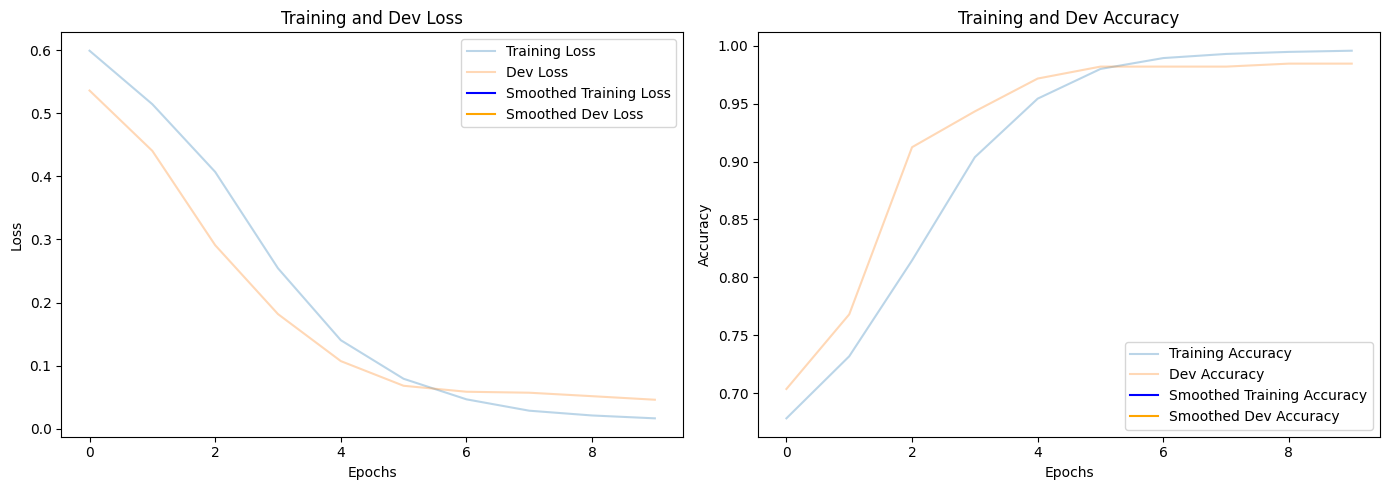

In [ ]:
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_losses, dev_losses, train_accuracy, and dev_accuracy are defined

# Convert lists to pandas Series
train_losses_series = pd.Series(train_losses)
dev_losses_series = pd.Series(dev_losses)
train_accuracy_series = pd.Series(train_accuracy)
dev_accuracy_series = pd.Series(dev_accuracy)

# Calculate moving averages
window_size = 10  # Change this depending on the granularity of smoothing you need
smooth_train_losses = train_losses_series.rolling(window=window_size).mean()
smooth_dev_losses = dev_losses_series.rolling(window=window_size).mean()
smooth_train_accuracy = train_accuracy_series.rolling(window=window_size).mean()
smooth_dev_accuracy = dev_accuracy_series.rolling(window=window_size).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and Dev loss with moving averages
ax[0].plot(train_losses, label='Training Loss', alpha=0.3)
ax[0].plot(dev_losses, label='Dev Loss', alpha=0.3)
ax[0].plot(smooth_train_losses, label='Smoothed Training Loss', color='blue')
ax[0].plot(smooth_dev_losses, label='Smoothed Dev Loss', color='orange')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Dev Loss')
ax[0].legend()

# Plot training and Dev accuracy with moving averages
ax[1].plot(train_accuracy, label='Training Accuracy', alpha=0.3)
ax[1].plot(dev_accuracy, label='Dev Accuracy', alpha=0.3)
ax[1].plot(smooth_train_accuracy, label='Smoothed Training Accuracy', color='blue')
ax[1].plot(smooth_dev_accuracy, label='Smoothed Dev Accuracy', color='orange')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Dev Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:

model.eval()
with torch.no_grad():
  test_running_losses = []
  test_total = 0
  test_correct = 0
  for i, batch in enumerate(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs[0]
    # Convert outputs to predicted labels (0 or 1 based on threshold 0.5)
    _, indices = torch.max(outputs['logits'], dim=1)
    predicted_labels = indices.float()

    # Calculate accuracy
    test_total += batch['labels'].size(0)
    test_correct += (predicted_labels == batch['labels']).sum().item()
    test_running_losses.append(loss.item())

print(f'TEST: Loss: {sum(test_running_losses)/len(test_running_losses)} Acc: {test_correct/test_total}')

TEST: Loss: 1.0263221418857575 Acc: 0.7425259304453935


In [ ]:
for i in (range(5)):
  print(i)

0
1
2
3
4
